In [4]:
%load_ext autoreload
%autoreload 2

# add the parent directory in the path to import the packages
import sys
sys.path.append('../')

from WaterClassification.Radiometry import RadiometryDB
from WaterClassification.common import *
from WaterClassification.Fitting import BaseFit
from WaterClassification.Classification.clustering import *

import plotly.io as pio

from functools import partial
from pathlib import Path

# TODO
* Adicionar novas equacoes no fit
* Adicionar novas razoes de bandas
* refazer o calculo com essas novas equacoes apenas para os melhores resultados e até 15 clusters
* Analisar como estao ficando os clusters, por exemplo: com 6 clusters varias clusterizações mostram o mesmo resultado... mas a clusterização final é semelhante? Está separando o Negro?
* Grafico para caracterizar cada cluster (reflectância média com 1 desvio padrão)
* Como está ficando o fit dentro de cada cluster? Gráfico SPM estimado x SPM medido?
* Blending dos modelos
* Save Memory -> OK


 ## Load the Database

In [5]:
# Open the Radiometry Database
db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')

db.load_radiometries(r_types=['Rrs', 'Rrs_OSOAA'], 
                     norm=True,                                                        # create the normalized bands and also the area
                     funcs=partial(calc_area, col_name='flatness', norm_band='700'),   # create the flatness band
                     qry="SPM > 0 and Status != 'Deleted' and Status != 'Suspicious'"  # clear deleted and no data
                    )
rrs = db.rdmtries['Rrs']

rrs.head(3)

Radiometries ['Rrs', 'Rrs_OSOAA'] loaded in dictionary .rdmtries


,Area_2,Station_2,Measurement,Start_Date_2,SPM_2,Status_2,Description_2,319,320,321,...,n943,n944,n945,n946,n947,n948,n949,n950,n951,flatness
Id,,,,,,,,,,,,,,,,,,,,,
0,Descoberto,Ponto_1,20160318-1139,2016-03-18 11:39:00,7.0,Ok,GIANCARLO_ CAMP1_1,NaN,0.003272,0.003054,...,0.000138,0.000127,0.000149,0.000184,0.000180,0.000186,0.000191,0.000213,NaN,-1.480905
1,Descoberto,Ponto_2,20160318-1214,2016-03-18 12:14:00,8.4,Ok,GIANCARLO_ CAMP1_2,NaN,0.002663,0.002460,...,0.000193,0.000212,0.000206,0.000210,0.000192,0.000204,0.000186,0.000189,NaN,-1.484569
2,Descoberto,Ponto_3,20160318-1228,2016-03-18 12:28:00,5.8,Ok,GIANCARLO_ CAMP1_3,NaN,0.003356,0.003116,...,0.000143,0.000146,0.000142,0.000146,0.000158,0.000165,0.000162,0.000154,NaN,-1.755808


In [6]:
# deleting outliers
rrs.drop(index=[410, 418, 390, 520, 409, 658], inplace=True, errors='ignore')
len(rrs)

869

# Tests
Many studies have already proposed clusterization using the spectral reflectance to separate the water in classes. In this regard, it is usually chosen a clustering method and input features without further analysis on what which be the best combination of features/clustering algorithm. Thus, it is not assured the process will result in the best clusterization for a specific purpose. Besides that, as our objective is to ultimately maximize the accuracy of SPM inversion, the number of classes will depend on the performance of different mathematical models on each class, instead of relying on index such as silhouette or ????.<br>

In summary the parameters we will test are:
* The input features/reflectance type (raw, normalized, area) [raw wls, norm wls, raw + norm, norm + area, norm + 1raw]<br>
* Sampling [1nm, 10nm, 20nm, 30nm, s2bands, s3bands]
* Further Normalization [Standardization, Robust Normalization, etc.]
* Clustering algo [k-means, agglomerative, FCM]

For this first test, the input bands will be fixed to XXXXX


In the first tests, we will try different input features and different cross features normalization in order to 

In [277]:
from itertools import product
      
    
def parse_combination(combination):
    sampling, ref_type, normalization, algo = combination
    
    # first, get the input wavelenghts
    if isinstance(sampling, int):
        wls = wavelength_range(380, 940, step=sampling)
        wls_name = f'{sampling}nm'
    else:
        wls = sampling[0]
        wls_name = sampling[1]
        
    # create the bands, according to the reflectance types
    bands = []
    ref_type_name = '' 
    for tp in listify(ref_type):
        ref_type_name = ref_type_name + tp
        if tp == 'raw':
            bands = bands + wls
        elif tp == 'norm':
            bands = bands + [f'n{b}' for b in wls]
        else:
            bands = bands + listify(tp)
            
    name = '_'.join([algo, wls_name, ref_type_name, str(normalization)])
    
    return bands, name, normalization, algo


def full_process_clustering(df, range_clusters, samplings, ref_types, normalizations, algos, fit_bands, funcs, calc=False):
    combinations = list(product(samplings, ref_types, normalizations, algos))
    
    print(f'Total of {len(combinations)} were created.')    
    
    if not calc:
        return
    
    for combination in combinations:
        cluster_bands, name, normalization, algo = parse_combination(combination)
        
        print(f'**** {name} ****')
        
        mcluster = MultiClustering(df,
                                   cluster_features=cluster_bands,
                                   range_clusters=range_clusters,
                                   algo=algo,
                                   norm=normalization)
        
        mcluster.fit(fit_features=fit_bands, 
                     funcs=funcs, 
                     n_cpus=6, 
                     pool=None,
                     optimize_metric=True)
        
        # save the pandas summary
        result_df = mcluster.summary()
        result_df.to_csv(f'../data/{name}.csv')
        
        # save the figure
        fig = mcluster.plot_clustering('area', log_y=True)
        pio.write_image(fig, f'../data/{name}.png', width=1200, height=800)     



In [278]:
# de 400 a 920

samplings = [1, 
             10, 
             20, 
             30, 
             (s2bands, 's2bands'), 
             (s3bands, 's3bands')]

ref_types = ['raw', 'norm', ['raw', 'norm'], ['norm', 'area']]

normalizations = [None, 'Standard', 'Robust', 'MinMax']

algos = ['k-means', 'agglomerative', 'FCM']

fit_bands = s2bands + s2bands_norm + ['area', 'b865/b665']

full_process_clustering(rrs, (1, 7), samplings, ref_types, normalizations, algos, fit_bands, BaseFit.available_funcs, calc=False)

Total of 288 were created.


In [279]:
def get_clustering_results(output_path, samplings, ref_types, normalizations, algos, metric='RMSLE'):
    
    #listify all arguments
    samplings, ref_types, normalizations, algos = listify(samplings, ref_types, normalizations, algos)
    
    # get the combinations matching the input parameters
    combinations = list(product(samplings, ref_types, normalizations, algos))

    # loop trhough the combinations to get the names
    fnames = [Path(output_path)/f'{parse_combination(combination)[1]}.csv' for combination in combinations]
    
    # check if the files exists and create a dictionary with them
    files = {fname.stem: fname for fname in fnames if fname.exists()}

    # alert for missing names
    if len(fnames) != len(files):
        print(f'Files not found: {[fname.stem for fname in fnames if fname.stem not in files.keys()]}')

    if len(files) == 0:
        print('No files found. Quitting!')
    
    # open the dataframes in memory
    dfs = [pd.read_csv(fname, index_col=0) for fname in files.values()]
    
    # concat the results into a single dataframe
    df = pd.concat(dfs, keys=list(files.keys()), axis=0)
    return df

def plot_clustering_results(output_path, samplings, ref_types, normalizations, algos, metric='RMSLE'):
    # get the results combined into a single DataFrame
    df = get_clustering_results(output_path, samplings, ref_types, normalizations, algos, metric)
    
    df = df.swaplevel()
    df = df.loc[metric].reset_index().melt(id_vars=['index'])
    df['value'] = df['value'].astype('float')
    return px.line(df, x='variable', y='value', color='index')

# Testing the input features
Checking if the input should be raw, normalized, a combination of both or with 'area' parameter

Files not found: ['k-means_1nm_rawarea_None']


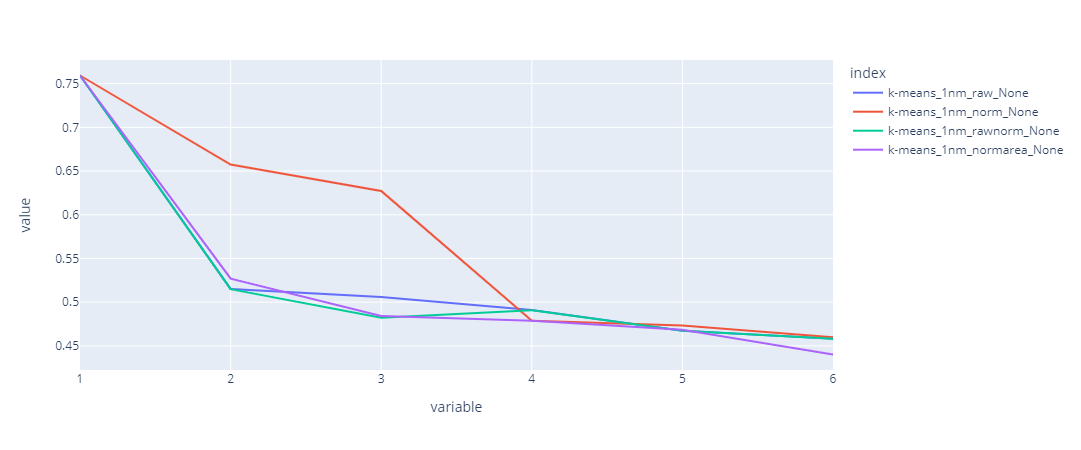

In [273]:
fig = plot_clustering_results('../data/', [1], ['raw', 'norm', ['raw', 'norm'], ['norm', 'area'], ['raw', 'area']], [None], ['k-means'])
fig

#### Checar se os clusters sao iguais lá no 6
For a small number of clusters, the results obtained with the area-normalized bands was the worst. Maybe it is due to a subdivision in low reflectance... to be confirmed with the graphic.<br>
Let's now see if normalization plays a role in the results:

# Testing Normalization

Files not found: ['k-means_1nm_rawarea_None', 'k-means_1nm_rawarea_Standard']


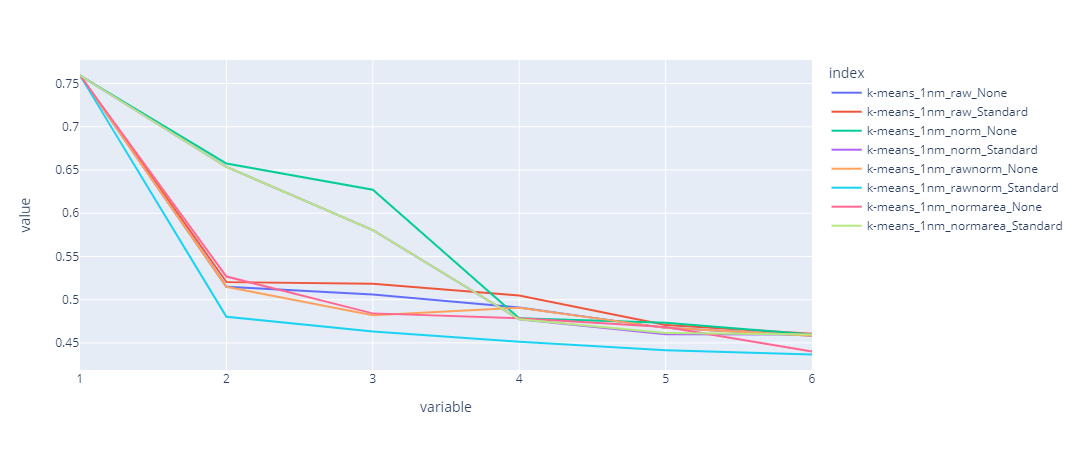

In [275]:
fig = plot_clustering_results('../data/', [1], ['raw', 'norm', ['raw', 'norm'], ['norm', 'area'], ['raw', 'area']], [None, 'Standard'], ['k-means'])
fig

Applying a post normalization to the RAW + NORM bands has improved substantially the results. This way, all the bands/features are considered with equal weights. A minimum error of 0.44 is achieved. <br>
Considering this best result, let's check if resampling the bands, instead of using the full spectra improves something. 

# Testing different "samplings"

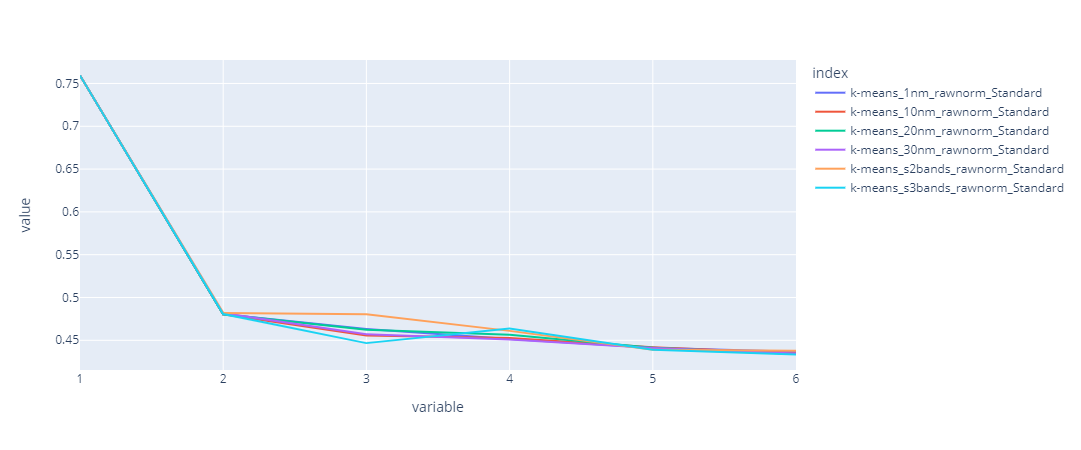

In [278]:
fig = plot_clustering_results('../data/', [1, 10, 20, 30, (s2bands, 's2bands'), (s3bands, 's3bands')], [['raw', 'norm']], ['Standard'], ['k-means'])
fig

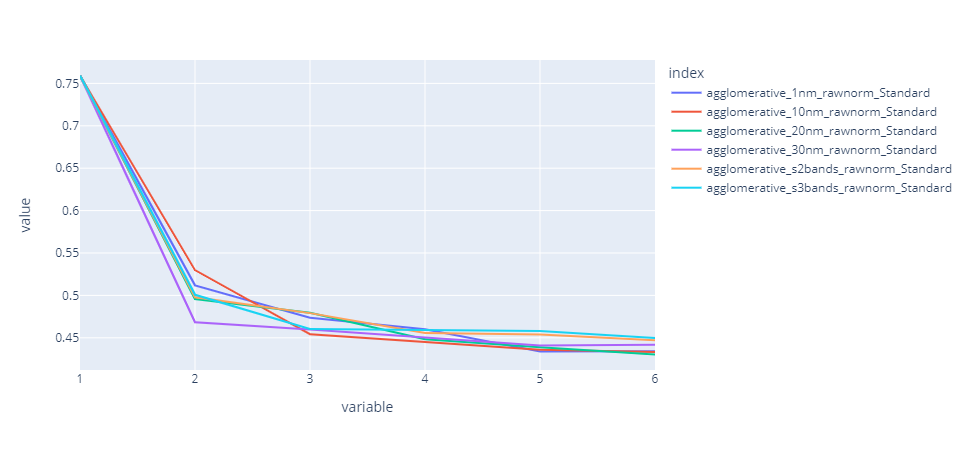

In [373]:
fig = plot_clustering_results('../data/', [1, 10, 20, 30, (s2bands, 's2bands'), (s3bands, 's3bands')], [['raw', 'norm']], ['Standard'], ['agglomerative'])
fig

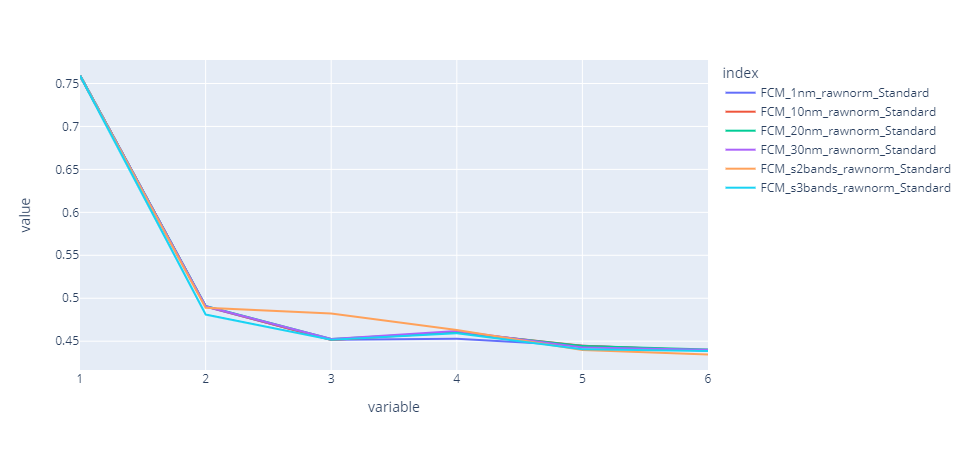

In [374]:
fig = plot_clustering_results('../data/', [1, 10, 20, 30, (s2bands, 's2bands'), (s3bands, 's3bands')], [['raw', 'norm']], ['Standard'], ['FCM'])
fig

The wavelenght sampling makes no difference in overall results. Even using just some bands as the ones from S2 or S3 will result in similar results. <br>
The last test will be to compare different clustering algorithms

# Testing different clustering algos

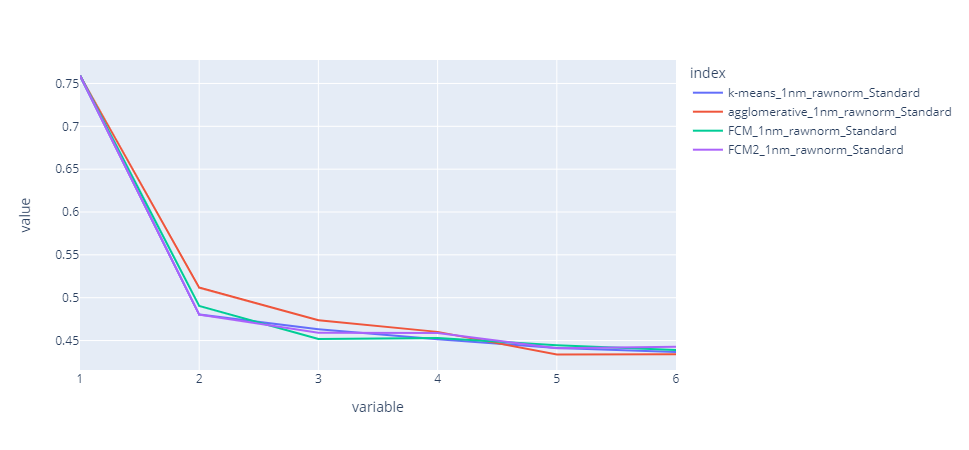

In [56]:
fig = plot_clustering_results('../data/', [1], [['raw', 'norm']], ['Standard'], ['k-means', 'agglomerative', 'FCM', 'FCM2'])
fig

The clustering algorithm does not change much the results.

# All Combinations

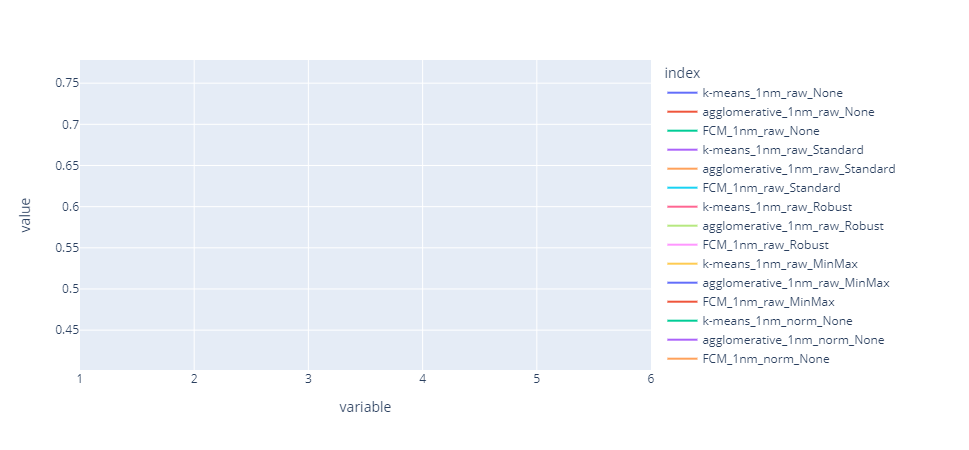

In [280]:
plot_clustering_results('../data/', samplings, ref_types, normalizations, ['k-means', 'agglomerative', 'FCM'])

# Testing the Model Blending Manually

In [7]:
mcluster = MultiClustering(df=rrs, 
                           cluster_features=all_wls+all_wls_norm,
                           range_clusters=(1,7),
                           norm='Standard',
                           algo='FCM')

mcluster.fit(fit_features=s2bands+s2bands_norm+['b865/b665'],
             funcs=BaseFit.available_funcs,
             optimize_metric=True,
             n_cpus=6)

In [8]:
mcluster.summary()

,1,2,3,4,5,6
R^2,0.403,0.881,0.8711,0.8948,0.8979,0.897
MSE,44798.8,8933.13,9671.8,7892.36,7664.32,7729.68
RMSE,211.657,94.5152,98.3453,88.839,87.5461,87.9186
RMSLE,0.7593,0.4903,0.4518,0.4529,0.4446,0.4389
SSE,3.89301e+07,7.76289e+06,8.40479e+06,6.85846e+06,6.66029e+06,6.71709e+06
qty,869,869,869,869,869,869
Samples,[869],"[496, 373]","[304, 284, 281]","[299, 231, 193, 146]","[229, 183, 170, 157, 130]","[174, 162, 160, 147, 125, 101]"


In [12]:
mcluster.blended_summary(threshold=0.6, factor=4)

,1,2,3,4,5,6
R^2,0.403,0.8811,0.8722,0.8953,0.903,0.8835
MSE,44798.8,8925.06,9593.85,7853.28,7275.61,8740.38
RMSE,211.657,94.4725,97.9482,88.6187,85.2972,93.49
RMSLE,0.7593,0.486,0.458,0.4547,0.4466,0.4455
SSE,3.89301e+07,7.75588e+06,8.33705e+06,6.8245e+06,6.3225e+06,7.59539e+06
params,None,None,None,None,None,None
y_hat,"[11.180271658799066, 10.91348780776025, 5.3717...","[11.678930683039308, 11.694940733507426, 11.69...","[7.663342379717557, 7.669700007439698, 7.67019...","[7.086283163124674, 7.1803915295020335, 5.7250...","[6.030481616302501, 6.0014583093286635, 5.4783...","[7.0521651909438905, 7.114978059770389, 6.3214..."


Resultado é que 